In [331]:
from functions import *
from scipy import stats
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [332]:
X = pd.read_csv("indep_x.csv", index_col = 0)
y = pd.read_csv("dep_y.csv", index_col = 0)

In [333]:
X_notreated = X.drop(["treated"], axis = 1)

In [334]:
X_notreated = X_notreated[X_notreated["gpa"]!=17]

In [335]:
data_nout = pd.read_csv("data_nout.csv", index_col = 0)

In [336]:
x_nout = data_nout[['age', 'gender', 'scholarship', '1st_year', 'gpa', '1st_time', 'taste',
                      'importance', 'expected_grade', 'knowledge']].copy()

y_nout = data_nout[['grade_goal','confidence', 'anxiety', 'time', 'exam_date']].copy()

treatment = data_nout["treated"].copy()

Total variance explained by the PCA 0.33257660380056875
Silhouette Score: 0.557955058501712


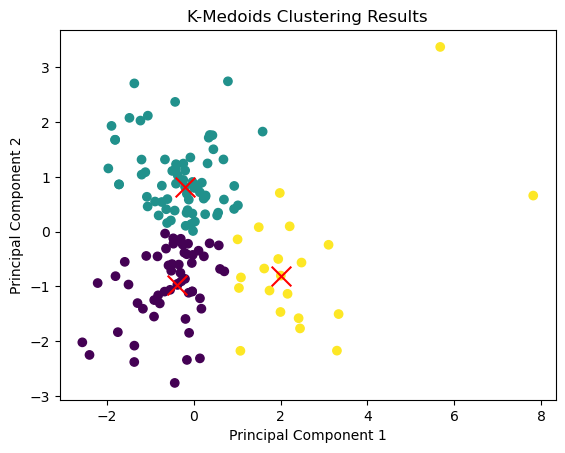

In [337]:
labels, centers = clustering_medoids_quick(X_notreated, n_comp= 2, dist_metric= "manhattan", n_clusters= 3, plot="yes");

In [338]:
centers_df = pd.DataFrame(centers)
centers_df.columns = X_notreated.columns

In [339]:
print(centers_df.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &     age &  gender &  scholarship &  1st\_year &     gpa &  1st\_time &  taste &  importance &  expected\_grade &  knowledge \\
\midrule
0 & 19.9812 &  0.2827 &      -0.0004 &    0.9597 & 24.5551 &    0.9867 & 3.7116 &      4.3324 &         21.2135 &     0.4178 \\
1 & 19.4255 &  0.6654 &       0.1655 &    0.9804 & 25.3893 &    0.9935 & 3.1493 &      3.7535 &         22.5788 &     0.2649 \\
2 & 20.8313 &  0.1371 &      -0.1014 &    0.6825 & 22.6403 &    0.8937 & 3.0200 &      3.5979 &         20.7348 &     0.1962 \\
\bottomrule
\end{tabular}



C:\Users\sav24\AppData\Local\Temp\ipykernel_13288\1217707605.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(centers_df.to_latex())


In [340]:
labels_df = pd.DataFrame(labels)
labels_df.columns = ["cluster"]
labels_df.index = X_notreated.index

In [341]:
(X_notreated.shape,labels_df.shape)

((145, 10), (145, 1))

In [342]:
X_cluster = pd.concat([X_notreated, labels_df], axis = 1)

In [343]:
X_cluster.shape

(145, 11)

In [344]:
treatment_status = X[X["gpa"]!=17]["treated"].copy()

In [345]:
X_cl_tstatus = pd.concat([X_cluster, treatment_status], axis = 1)

In [346]:
X_cl_tstatus.shape

(145, 12)

In [347]:
y_gpafixed = y[X["gpa"]!=17].copy()
y_gpafixed = pd.concat([y_gpafixed, labels_df], axis = 1)

In [348]:
ate_results = {}
p_values = {}

for cluster_id in X_cl_tstatus['cluster'].unique():
    ate_results[cluster_id] = {}
    p_values[cluster_id] = {}
    for var in y_gpafixed.columns[:-1]:
        cluster_data = X_cl_tstatus[X_cl_tstatus['cluster'] == cluster_id].drop(["cluster"], axis = 1)
        X = sm.add_constant(cluster_data) 
        y_reg = y_gpafixed[y_gpafixed['cluster'] == cluster_id].copy()
        y_reg = y_reg[var] 
        model = sm.OLS(y_reg, X).fit(cov = "HC3")
        ate_results[cluster_id][var] = model.params['treated']
        p_values[cluster_id][var] = model.pvalues['treated']

In [349]:
ate_df = pd.DataFrame(ate_results)
p_values_df = pd.DataFrame(p_values)

In [350]:
pd.options.display.float_format = '{:.4f}'.format

In [351]:
X_cl_tstatus["cluster"].value_counts()

1    69
0    55
2    21
Name: cluster, dtype: int64

In [352]:
print(ate_df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &       1 &       2 &       0 \\
\midrule
grade\_goal & -2.5277 & -2.4161 &  0.1311 \\
confidence & -0.4149 & -0.1488 &  0.1495 \\
anxiety    &  0.2755 & -0.2258 & -0.0249 \\
time       &  0.4722 &  0.5130 &  0.2657 \\
exam\_date  & -0.0185 & -0.5048 &  0.0894 \\
\bottomrule
\end{tabular}



C:\Users\sav24\AppData\Local\Temp\ipykernel_13288\3187110854.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ate_df.to_latex())


In [353]:
X_cluster.groupby("cluster")[X_cluster.columns].mean()

,age,gender,scholarship,1st_year,gpa,1st_time,taste,importance,expected_grade,knowledge,cluster
cluster,,,,,,,,,,,
0,19.7455,0.2000,0.0000,1.0000,24.5818,0.9818,3.7636,4.3455,21.4364,0.4364,0.0000
1,19.3043,0.7681,0.1594,1.0000,25.5797,1.0000,3.1159,3.7536,22.4783,0.2609,1.0000
2,21.4762,0.1905,0.0000,0.5714,22.6190,0.9048,2.9048,3.4762,21.0952,0.1429,2.0000


In [354]:
y_gpafixed.groupby("cluster")[y_gpafixed.columns].mean()

,grade_goal,confidence,anxiety,time,exam_date,cluster
cluster,,,,,,
0,25.1636,3.5091,3.3273,4.6545,1.0909,0.0000
1,25.6522,3.4928,3.4058,4.5507,1.1014,1.0000
2,23.3333,3.3810,3.0000,4.6667,1.3810,2.0000


In [355]:
print(p_values_df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &      1 &      2 &      0 \\
\midrule
grade\_goal & 0.0000 & 0.0902 & 0.8972 \\
confidence & 0.0698 & 0.6625 & 0.5632 \\
anxiety    & 0.3187 & 0.5560 & 0.9196 \\
time       & 0.0794 & 0.4435 & 0.3410 \\
exam\_date  & 0.8119 & 0.1943 & 0.3126 \\
\bottomrule
\end{tabular}



C:\Users\sav24\AppData\Local\Temp\ipykernel_13288\1627883584.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(p_values_df.to_latex())


### Tests

In [366]:
cluster_1_gg = y_gpafixed[y_gpafixed["cluster"]==2]["grade_goal"].values
cluster_2_gg = y_gpafixed[y_gpafixed["cluster"]==1]["grade_goal"].values

In [367]:
stats.ttest_ind(cluster_1_gg, cluster_2_gg)[1]

0.004129923351882911

In [368]:
y_gpafixed[X_cl_tstatus["cluster"]==2]["grade_goal"].mean()

23.333333333333332

In [369]:
y_gpafixed[X_cl_tstatus["cluster"]==1]["grade_goal"].mean()

25.652173913043477

In [358]:
t_results = {}

for cluster_id in X_cl_tstatus['cluster'].unique():
    t_results[cluster_id] = {}
    for var in y_gpafixed.columns[:-1]:
        cluster_2= y_gpafixed[X_cl_tstatus["cluster"]==0][var].values
        cluster_1 = y_gpafixed[X_cl_tstatus["cluster"]==1][var].values
        cluster_0 = y_gpafixed[X_cl_tstatus["cluster"]==2][var].values

        t_results[var] = {"0-1": stats.ttest_ind(cluster_0, cluster_1)[1],
                          "1-2": stats.ttest_ind(cluster_1, cluster_2)[1],
                          "2-0": stats.ttest_ind(cluster_2, cluster_0)[1],
                          }

In [371]:
pd.DataFrame(t_results)[["grade_goal", "confidence", "anxiety", "time", "exam_date"]]

,grade_goal,confidence,anxiety,time,exam_date
0-1,0.0041,0.6167,0.1122,0.6981,0.0131
1-2,0.4000,0.9210,0.6550,0.5868,0.8452
2-0,0.0411,0.5699,0.1471,0.9654,0.0158


In [ ]:
y_var = y_gpafixed["grade_goal"].copy()

### Regression Tests

In [372]:
X_dummies = pd.get_dummies(X_cl_tstatus, columns=['cluster'], drop_first=True, dtype = int)

In [374]:
X_reg = X_dummies[['cluster_1', 'cluster_2','treated']].copy()
X_reg = sm.add_constant(X_reg)

In [383]:
X_reg.columns

Index(['const', 'cluster_1', 'cluster_2', 'treated'], dtype='object')

In [385]:
reg_results = {}
p_values = {}

for var in y_gpafixed.columns[:-1]:
    model = sm.OLS(y_gpafixed[var], X_reg).fit(cov = "HC3")
    reg_results[var] = {"Cluster 1": model.params['cluster_1'], "Cluster 2": model.params['cluster_2']}
    p_values[var] = {"Cluster 1": model.pvalues['cluster_1'], "Cluster 2": model.pvalues['cluster_2']}

In [388]:
print(pd.DataFrame(reg_results).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  grade\_goal &  confidence &  anxiety &    time &  exam\_date \\
\midrule
Cluster 1 &      0.4043 &     -0.0275 &   0.0821 & -0.0710 &     0.0059 \\
Cluster 2 &     -2.1623 &     -0.1723 &  -0.3131 &  0.1416 &     0.2716 \\
\bottomrule
\end{tabular}



C:\Users\sav24\AppData\Local\Temp\ipykernel_13288\324740429.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(reg_results).to_latex())


In [389]:
print(pd.DataFrame(p_values).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  grade\_goal &  confidence &  anxiety &   time &  exam\_date \\
\midrule
Cluster 1 &      0.4920 &      0.8659 &   0.6392 & 0.7225 &     0.9345 \\
Cluster 2 &      0.0126 &      0.4692 &   0.2212 & 0.6271 &     0.0099 \\
\bottomrule
\end{tabular}



C:\Users\sav24\AppData\Local\Temp\ipykernel_13288\181048351.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(p_values).to_latex())


In [ ]:
X_reg2 = X_dummies[['age', 'gender', 'scholarship', '1st_year', 'gpa', '1st_time', 'taste',
                    'importance', 'expected_grade', 'knowledge',
                    "treated"]].copy()

In [ ]:
model2 = sm.OLS(y_var, sm.add_constant(X_reg2)).fit(cov = "HC3")
model2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.311   
Dependent Variable: grade_goal       AIC:                716.8011
Date:               2025-03-29 10:43 BIC:                752.5219
No. Observations:   145              Log-Likelihood:     -346.40 
Df Model:           11               F-statistic:        6.919   
Df Residuals:       133              Prob (F-statistic): 3.73e-09
R-squared:          0.364            Scale:              7.5871  
-----------------------------------------------------------------
                  Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
-----------------------------------------------------------------
const            -4.7334   5.8303 -0.8119 0.4183 -16.2654  6.7987
age               0.2217   0.2148  1.0319 0.3040  -0.2032  0.6466
gender            0.3988   0.4915  0.8113 0.4186  -0.5734  1.3710
scholarship       0.1035   0.9061  0.1142 0.9092  -1.6887  1.8958
1st_year          1.1857   1.0915  1.0863 0.2793  -0.9733  3.3447
gpa               0.4354   0.0972  4.4804 0.0000   0.2432  0.6277
1st_time         -0.8205   1.6703 -0.4912 0.6241  -4.1242  2.4832
taste             1.1483   0.4131  2.7801 0.0062   0.3313  1.9654
importance        0.4802   0.3910  1.2282 0.2215  -0.2931  1.2535
expected_grade    0.4177   0.0966  4.3235 0.0000   0.2266  0.6088
knowledge         0.2814   0.5171  0.5441 0.5873  -0.7415  1.3042
treated          -1.4621   0.4800 -3.0460 0.0028  -2.4116 -0.5127
-----------------------------------------------------------------
Omnibus:              4.085        Durbin-Watson:           1.936
Prob(Omnibus):        0.130        Jarque-Bera (JB):        4.682
Skew:                 0.137        Prob(JB):                0.096
Kurtosis:             3.836        Condition No.:           997  
=================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""